In [1]:
# libraries
library(stats)
library(gmodels)
library(loadings)
library(tidyverse)
library(dpylr)
library(pheatmap)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.4.1     v purrr   0.3.4
v tibble  3.1.8     v dplyr   1.0.9
v tidyr   1.2.1     v stringr 1.4.1
v readr   2.1.3     v forcats 0.5.2

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



ERROR: Error in library(dpylr): there is no package called 'dpylr'


In [6]:
# functions


multi.intersect <- function(x) Reduce(intersect, x)

pseudocount_log2p1_transform <- function(x, scale_factor = 10^6, UMI.provided = NULL){
  # Almost as Seurat::NormalizeData but we use log2 rather than natural log
  # from here https://satijalab.org/seurat/reference/normalizedata
  if(is.null(UMI.provided)){
    counts <- sum(x)}else{
      counts <- UMI.provided
    }
  x <- (x)/counts # Feature counts for each cell are divided by the total counts for that cell...
  x <- x*scale_factor # and multiplied by the scale.factor. 
  # the we log2 plus 1 rather than natural log plus 1 seurat uses
  return(log2(x+1))
}

pavlab.normalize <- function(df, UMI = NULL, median.scale=FALSE, scaleby = 10000){
  df.cols <- colnames(df)
  df.rows <- rownames(df)
  if(median.scale){ scaleby = median(UMI)}
  if( is.null(UMI)){
    df <- data.frame(apply(df,  MARGIN = 2, pseudocount_log2p1_transform))
  }else{
    #
    df[] <- Map(pseudocount_log2p1_transform, df, scale_factor = scaleby, UMI.provided = UMI)
    
  }
  colnames(df) <- df.cols
  rownames(df)<- df.rows
  return(df)
}


#normalization functions, log.norm calls logplusone
seurat_log1p_transform <- function(x, scale_factor = 10000, UMI.provided = NULL){
  # as per the LogNormalize option in Seurat::NormalizeData
  # from this URL: https://satijalab.org/seurat/reference/normalizedata
  if(is.null(UMI.provided)){
    counts <- sum(x)}else{
      counts <- UMI.provided
    }
  x <- (x)/counts # Feature counts for each cell are divided by the total counts for that cell... 
  x <- x*scale_factor # and multiplied by the scale.factor. 
  # This is then natural-log transformed using log1p.
  return(log(x+1))
}

seurat.normalize <- function(df, UMI = NULL, median.scale=FALSE, scaleby = 10000){
  df.cols <- colnames(df)
  df.rows <- rownames(df)
  if(median.scale){ scaleby = median(UMI)}
  if( is.null(UMI)){
    df <- data.frame(apply(df,  MARGIN = 2, seurat_log1p_transform))
  }else{
    #
    df[] <- Map(seurat_log1p_transform, df, UMI.provided = UMI, scale_factor = scaleby)
  }
  colnames(df) <- df.cols
  rownames(df)<- df.rows
  return(df)
}

#functions
logplusone <- function(x){
  if (sum(x)==0){
  y <- x}else{
  y <- log(x+1)}    
  return( y )
}

# this gives zeros don't use it
log.norm <- function(df.in){
  #performs the lognorm transform and scales the data, removes NA's first
  if( sum(is.na(df.in)) ){
    df.in[is.na(df.in)] <- 0
  }
  df.out <- apply(df.in,
                  MARGIN = 1,
                  FUN = logplusone
  )
  df.out <- scale( t(df.out) ) #we need it transposed so that the scaling is done per gene not cell
  df.out <- data.frame( t(df.out) )
  colnames(df.out) <- rownames(df.in)
  return(df.out)
}

#modified original is in ChenClassifier.R in the EngramCellClassifier folder
celltype.lognorm <-function(countsdata, celltype.labels){
  #log normalizes within cell types in counts data
  #celltype labels and colnames of countsdata must have same order
  
  #retunrs a transposed and normalize dataframe 
  
  print("Normalizing cell type...")
  
  celltypes <- unique(celltype.labels)
  df.out <- data.frame(gene = rownames(countsdata))
  #df.out <- t(df.out)
  #colnames(df.out) <- rownames(countsdata)
  
  cell_names <- c('gene',colnames(countsdata)) # keep this for reorganizing later
  df.out.rownames <- c()
  for(type in celltypes){
    print(type[1])
    normalized.within.type <- log.norm(countsdata[,celltype.labels==type])
    normalized.within.type <- t(normalized.within.type) # lognorm flips its data
    normalized.within.type <- data.frame(normalized.within.type)
    normalized.within.type <- rownames_to_column(normalized.within.type, var ="gene")
    df.out <- left_join( df.out, normalized.within.type, by = 'gene' )
  }
  
  #df.out <- df.out[,2:dim(df.out)[2]]  # to keep original order
  df.out <- df.out[cell_names] %>% 
    select_if(~ !any(is.na(.))) %>%
    column_to_rownames(var = 'gene')
    
  return( data.frame(df.out) ) 
}


ieg_expression_sum <- function(assay_normed, ieg_list){
  # activity sum of expression of genes after normlization by umi and
  # scaled by median umi
  ieg.idx <- match(target_IEGs, rownames(assay_normed))
  ieg.idx <- ieg.idx[!is.na(ieg.idx)]
  return( colSums(assay_normed[ieg.idx,]) )
}





ieg_thresholding <-function(assay_normed,
                            ieg_list,
                            percentile_lowerbound = 0.99,
                            return_colnames = TRUE){
  # PARAMETERS:
  # assay_normed : data frame (genes by cells)
  # ieg_list : list of iegs to check if cells are expressing above percentile lower bound
  # percentile_lowerbound : the percentile of an ieg's expression a cell needs to pass
  # return_colnames : default true, if false logical vector is returned true for a cell that passed
  #RETURNS:
  # high_ieg_cells : colnaems of cell that expressed one ieg in teh percentile chosen, or logical vetor same length as assya_normed cols true where cell passed
  
  
  # instantiate vector which keeps track of which cells
  # are expressing one ieg in the ieg_list above the
  # lower percentile bound for all cells
  is_high_ieg <- rep(FALSE, each = dim(assay_normed)[2])

  for(ieg in ieg_list){
    # get row number of ieg
    gene.idx <- rownames(assay_normed) %in% ieg
    #get numeric values of that iegs expression in every cell,
    # needs to be converted to numeric or it jsut returns colnames
    ieg_expression <- as.numeric(assay_normed[gene.idx,])
    #use percentile to get the threshold for this gene, again as.numeric for just the float value
    thresh <- as.numeric(quantile(ieg_expression , probs = percentile_lowerbound))
    # if a cell has previously been found to pass another ieg's thresh make it true,
    # OR if it passes this ieg's thresh make it true, keeps a rolling tally of the cells that pass
    # for at least one ieg
    is_high_ieg <- is_high_ieg |  (ieg_expression > thresh)
    }
          
  # return the colnames,
  # if return_colnaems is false returns a binary vector of 
  # length of columns of assay_normed
  if(return_colnames){
    high_ieg_cells <- colnames(assay_normed)[is_high_ieg]
  }else{
    high_ieg_cells <- is_high_ieg
  }
  return(high_ieg_cells)
}

# not working for some reason 
cell.type.proportion <-function (active_cells, cell_name_list, cell_type_list){
  # Returns proportion of cells that are active in a population
  # active_cells : list of cell names of teh active cells from ieg_thrsholding()
  # cell_name_list : list of cells in the whole assay from assay_normed in ieg_thresholding active and inactive
  # cell_type_list : list of the types of cells corresponding to the whole assay active and inactive
  # NOTE WE ASSUME cell_name_list and cell_type_list corespond to each other, same length and
  # each entry corresponds to the same cell (some of which are in active_cells)
  cell_type_activity <- table(cell_type_list[cell_name_list %in% test])
  
  for(cell.type in names(cell_type_activity)){
    proportion_of_active_cells <- cell_type_activity[cell.type]/sum(cell_type_list == cell.type)
    cell_type_activity[cell.type] <- proportion_of_active_cells
  }
return(cell_type_activity)
}


In [6]:
saunders2018_dgc_counts.normscaled <- read.csv('/home/acampbell/PavLabEngrams/saunders2018_dgc_counts_normscaled.csv')

#make cell names is X column rownames and drop X
rownames(saunders2018_dgc_counts.normscaled) <- saunders2018_dgc_counts.normscaled$X
saunders2018_dgc_counts.normscaled <- saunders2018_dgc_counts.normscaled %>% select(-X)

In [7]:
# confirm it looks good to go
head(saunders2018_dgc_counts.normscaled)

,X0610005C13RIK,X0610007P14RIK,X0610009B22RIK,X0610009E02RIK,X0610009L18RIK,X0610009O20RIK,X0610010F05RIK,X0610010K14RIK,X0610011F06RIK,X0610025J13RIK,...,ZYX,ZZEF1,ZZZ3,L7RN6,MMU.MIR.684.1,MMU.MIR.684.2,MMU.MIR.703,N.R5.8S1,N.R5S202,N.R5S8
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P60HippoRep1P1_CGCCATGAACCT,-0.02163471,1.552608,1.6898355,-0.09427871,-0.2882257,3.3306703,-0.387951,-0.04148013,1.414048,-0.0197327,...,2.4527747,-0.4152217,-0.4414875,1.2163365,-0.01976321,-0.07306755,-0.6038495,-0.1432553,-0.03638278,-0.02160563
P60HippoRep1P1_TACACCAACTAT,-0.02163471,2.025742,1.7278914,-0.09427871,-0.2882257,3.3941745,-0.387951,-0.04148013,1.448478,-0.0197327,...,2.1277500,-0.4152217,1.7361504,1.2484200,-0.01976321,-0.07306755,1.4737999,-0.1432553,-0.03638278,-0.02160563
P60HippoRep1P1_TGGTTCGGCTAT,-0.02163471,-0.566436,-0.4489106,-0.09427871,-0.2882257,-0.2382694,-0.387951,-0.04148013,1.506192,-0.0197327,...,-0.3735777,-0.4152217,-0.4414875,1.8448913,-0.01976321,-0.07306755,-0.6038495,-0.1432553,-0.03638278,-0.02160563
P60HippoRep1P1_CCTTTGCCTCGA,-0.02163471,1.366687,-0.4489106,-0.09427871,-0.2882257,-0.2382694,-0.387951,-0.04148013,1.509140,-0.0197327,...,-0.3735777,1.9363663,1.8032257,1.9352375,-0.01976321,-0.07306755,1.6865840,-0.1432553,-0.03638278,-0.02160563
P60HippoRep1P1_CTGTCATACCCC,-0.02163471,1.387984,-0.4489106,9.04994989,-0.2882257,3.5473117,-0.387951,-0.04148013,1.531505,-0.0197327,...,-0.3735777,-0.4152217,-0.4414875,1.5968247,-0.01976321,-0.07306755,1.2830538,-0.1432553,-0.03638278,-0.02160563
P60HippoRep1P1_ACGTTGGATTCT,-0.02163471,1.667847,-0.4489106,-0.09427871,2.9402109,-0.2382694,-0.387951,-0.04148013,-0.520934,-0.0197327,...,-0.3735777,1.9657773,-0.4414875,-0.5867551,-0.01976321,-0.07306755,1.7100497,-0.1432553,-0.03638278,-0.02160563


In [24]:
dim(saunders2018_dgc_counts.normscaled)

[1] 12750 15292

In [9]:
# its already been scaled and normed so lets
saunders.prcomp <- fast.prcomp(saunders2018_dgc_counts.normscaled, center = FALSE)
saunders.prcomp <- pca_loading(saunders.prcomp)
saveRDS(saunders.prcomp, file = '/space/scratch/PCArds_objects_DGCs/pca_sauders_allgenes.RDS')

In [12]:
pcs.varexplained <-saunders.prcomp$sdev^2/sum(saunders.prcomp$sdev^2)

In [13]:
# varience explained plot
pcs.varexplained <-saunders.prcomp$sdev^2/sum(saunders.prcomp$sdev^2)

pc.df <- data.frame( PC = colnames(saunders.prcomp$x)[1:10],
    varience = pcs.varexplained[1:10]) %>% arrange(desc(varience))

pc.df$varience <- round(pc.df$varience*100, digits = 2)
pc.df$varience

[1] 1.25 0.45 0.13 0.11 0.07 0.06 0.06 0.05 0.05 0.05

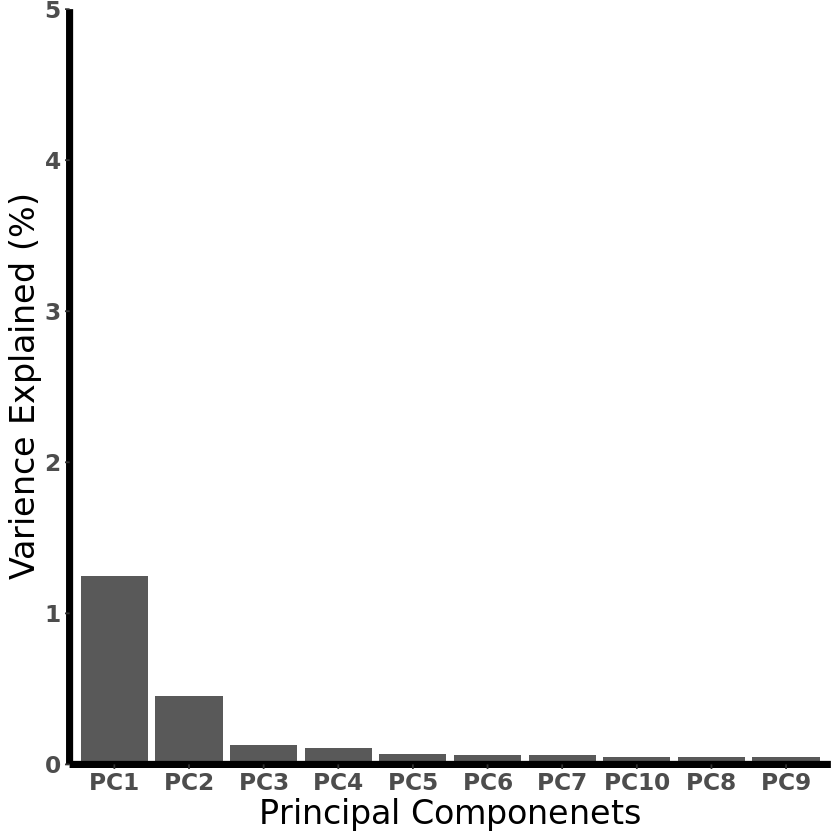

In [15]:
#plotting
ggplot(data = pc.df, aes(x = reorder(PC, -varience), y = varience)) + 
geom_bar(stat ="identity") +
theme_classic() +
xlab('Principal Componenets') +
ylab('Varience Explained (%)' ) +
scale_y_continuous(expand = c(0, 0),limits=c(0, 5)) +
theme(axis.line=element_line(size=2)) + 
theme(axis.line=element_line(size=2),
     axis.title.x = element_text(size = 20),
      axis.title.y = element_text(size = 20),
     axis.text.x = element_text(size = 14, face = "bold"),
     axis.text.y = element_text(size = 14, face = "bold" ))

In [25]:
df <- as.data.frame(saunders.prcomp$rotation) %>% select(c('PC1','PC2')) %>% arrange(desc(PC1))
head(df,50)

,PC1,PC2
,<dbl>,<dbl>
X2010107E04RIK,0.02411686,-0.03777677
SLC25A5,0.02400034,-0.02824817
COX7B,0.02395070,-0.03443163
COX7A2,0.02383664,-0.04322644
MLLT11,0.02351892,-0.02814934
UQCRH,0.02314539,-0.03038280
PSMA2,0.02305578,-0.03053622
RPS21,0.02280798,-0.03076481
ATP5J2,0.02279252,-0.03507483


In [26]:
df <- df %>% arrange(PC1)
head(df,50)

,PC1,PC2
,<dbl>,<dbl>
PPP3CA,-0.023235813,0.0649827564
MALAT1,-0.019721011,0.0585033118
MAP1B,-0.010282045,0.0645757164
PENK,-0.004600189,-0.0016519818
TTC3,-0.003505781,0.0409393915
CAMK2N1,-0.003452617,0.0103815939
OLFM1,-0.002186752,-0.0076151761
RP23.120C8.3,-0.002169231,0.0049923642
CPLX2,-0.001968924,0.0143360930


In [30]:
saundersdgs2018s.meta <- read.csv('/space/scratch/Saunders2018_Hp_GSE116470/saunders2018_dgc_meta_filtered_v2.csv')
rownames(saundersdgs2018s.meta) <- saundersdgs2018s.meta$X
saundersdgs2018s.meta <- select(saundersdgs2018s.meta, -X)

In [46]:
bahl2022.path <- '/home/acampbell/PavLabEngrams/IEG_gradients/neurestimator_iegs_list.csv'
bahl.meta.iegs.df <- read.csv(bahl2022.path)
meta.iegs <- toupper(bahl.meta.iegs.df$stimulus_responsive_gene)
meta.iegs

[1] "ARC"      "ATF3"     "BTG2"     "CCDC184"  "COQ10B"   "CREM"    
 [7] "CSRNP1"   "DUSP1"    "DUSP5"    "EGR1"     "EGR2"     "EGR3"    
[13] "ERRFI1"   "FBXO33"   "FOS"      "FOSB"     "FOSL2"    "GADD45G" 
[19] "GMEB2"    "GRASP"    "HERPUD1"  "IER2"     "JUNB"     "KLF4"    
[25] "MBNL2"    "NPAS4"    "NR4A1"    "NR4A2"    "NR4A3"    "PCSK1"   
[31] "PEG10"    "PER1"     "PLAGL1"   "PPP1R15A" "PTGS2"    "REM2"    
[37] "RGS2"     "SERTAD1"  "SIK1"     "STARD4"   "TIPARP"

In [55]:
filtcells.idx <- rownames(saunders2018_dgc_counts.normscaled)  %in% rownames(saundersdgs2018s.meta)
saunders2018_dgc_counts.test <- saunders2018_dgc_counts.normscaled[filtcells.idx,]


In [37]:
colnames(saunders.prcomp$x)[1:5]

[1] "PC1" "PC2" "PC3" "PC4" "PC5"

In [39]:
colnames(saundersdgs2018s.meta)

[1] "orig.ident"                     "nCount_RNA"                    
 [3] "nFeature_RNA"                   "cluster"                       
 [5] "subcluster"                     "reason"                        
 [7] "nCount_SCT"                     "nFeature_SCT"                  
 [9] "celltype"                       "class"                         
[11] "region"                         "common_name"                   
[13] "percent.mt"                     "RNA_snn_res.0.1"               
[15] "seurat_clusters"                "pointone_res_cluster_nums"     
[17] "pointone_res_cluster_mrkrs"     "RNA_snn_res.0.5"               
[19] "RNA_snn_res.1"                  "RNA_snn_res.2"                 
[21] "testclust"                      "RNA_snn_res.0.4"               
[23] "RNA_snn_res.0.3"                "pointthree_res_cluster_nums"   
[25] "pointthree_res_cluster_mrkrs"   "RNA_snn_res.4"                 
[27] "HIGHRES_CLUSTERS_four_res_nums" "dgc.subtypes"                  
[29] "type_cluster.k6.h1.75"          "subtype_cluster.k44.h0.35"     
[31] "subtypes_cluster.k6.h1.75"      "subclass_hclust.k6.h1.75"      
[33] "subtype_hclust.k44.h0.35"       "tPC1_score"

In [41]:
table(saundersdgs2018s.meta$subclass_hclust.k6.h1.75)


  DGC-CAPN3     DGC-CCK    DGC-MEG3 DGC-NEUROD2    DGC-PENK   DGC-USMG5 
       2862        1074        1650        3202        1759        2203 

In [56]:
saundersdgs2018s.meta$tPC1_score <- saunders.prcomp$x[,1]

matched.iegs <- colnames(saunders2018_dgc_counts.test)[colnames(saunders2018_dgc_counts.test) %in% meta.iegs]

In [57]:
matched.iegs

[1] "ARC"      "ATF3"     "BTG2"     "CCDC184"  "COQ10B"   "CREM"    
 [7] "CSRNP1"   "DUSP1"    "DUSP5"    "EGR1"     "EGR2"     "EGR3"    
[13] "ERRFI1"   "FBXO33"   "FOS"      "FOSB"     "FOSL2"    "GADD45G" 
[19] "GRASP"    "HERPUD1"  "IER2"     "JUNB"     "KLF4"     "MBNL2"   
[25] "NPAS4"    "NR4A1"    "NR4A2"    "NR4A3"    "PCSK1"    "PEG10"   
[31] "PER1"     "PLAGL1"   "PPP1R15A" "PTGS2"    "REM2"     "RGS2"    
[37] "SERTAD1"  "SIK1"     "STARD4"   "TIPARP"

In [59]:
#saundersdgs2018s.meta$iegsum_activity <- colSums(saunders2018_dgc_counts.test[,matched.iegs])

#sample_name, tPC1_score, iegsum_activity, cell_class, cell_subclass, cell_cluster
#colSums(saunders2018_dgc_counts.test[matched.iegs,])[1:10]
saundersdgs2018s.meta$iegsum_activity <- rowSums(saunders2018_dgc_counts.test[,matched.iegs])

In [60]:
# construct dataframe from this pc score
tPC1cell.idx.df <- saundersdgs2018s.meta %>% 
                   select( tPC1_score, iegsum_activity, subclass_hclust.k6.h1.75, subtype_hclust.k44.h0.35)  %>% 
                   arrange(tPC1_score)

In [61]:
tPC1cell.idx.df$subclass_hclust.k6.h1.75 <- as.factor(tPC1cell.idx.df$subclass_hclust.k6.h1.75)
tPC1cell.idx.df$subtype_hclust.k44.h0.35 <- as.factor(tPC1cell.idx.df$subtype_hclust.k44.h0.35)

In [62]:
# getting the gene loadings out
# finding out which are significant
# could also check to see if they are a TF or not
tPC1_fromsaunders2018.dgcs <- data.frame(gene = colnames(saunders2018_dgc_counts.test),
                                           tPC1 = saunders.prcomp$loading$R[,1],
                                 p.value = saunders.prcomp$loading$p.value[,1],
                                q.value_BH = p.adjust(saunders.prcomp$loading$p.value[,1], method='BH')) %>% arrange(tPC1)
head(tPC1_fromsaunders2018.dgcs)

,gene,tPC1,p.value,q.value_BH
,<chr>,<dbl>,<dbl>,<dbl>
PPP3CA,PPP3CA,-0.32135982,3.990341e-304,1.017005e-300
MALAT1,MALAT1,-0.27274881,2.627984e-216,2.220284e-214
MAP1B,MAP1B,-0.14220446,1.387439e-58,6.194660e-58
PENK,PENK,-0.06362231,6.453054e-13,1.197865e-12
TTC3,TTC3,-0.04848624,4.312505e-08,7.054645e-08
CAMK2N1,CAMK2N1,-0.04775096,6.875656e-08,1.117468e-07


In [128]:
jeager.DEGs.path <- '/home/acampbell/PavLabEngrams/EngramCellClassifier/Jeager2018_GSE98679/jeager_DEGs_grouped.csv'
jeager.DEGs.df <- read.csv(jeager.DEGs.path)
rownames(jeager.DEGs.df) <- jeager.DEGs.df$X...gene
jeager.DEGs.df <- jeager.DEGs.df %>% select(-X...gene)
jeager.DEGs.df$uppercaseSymbol <- toupper(rownames(jeager.DEGs.df)) # necause of saunders making all the gene symbols in all caps 

In [129]:
head(jeager.DEGs.df)

,group,group.number,uppercaseSymbol
,<chr>,<int>,<chr>
1110038B12Rik,1hr,1,1110038B12RIK
1810030O07Rik,1hr,1,1810030O07RIK
2010111I01Rik,1hr,1,2010111I01RIK
5031439G07Rik,1hr,1,5031439G07RIK
Abca5,1hr,1,ABCA5
Abhd2,1hr,1,ABHD2


In [130]:
jeager.degs.onehour <- jeager.DEGs.df$uppercaseSymbol[jeager.DEGs.df$group =='1hr']

In [147]:
# filtering for the iegs correlated to 
fdr.thresh <- 0.01
#iegs.tPC1_ranking <- tPC1_fromsaunders2018.dgcs[(tPC1_fromsaunders2018.dgcs$q.value_BH<fdr.thresh)&(tPC1_fromsaunders2018.dgcs$gene %in% meta.iegs),]
#iegs.tPC1_ranking <- tPC1_fromsaunders2018.dgcs[tPC1_fromsaunders2018.dgcs$gene %in% meta.iegs,]
iegs.tPC1_ranking <- tPC1_fromsaunders2018.dgcs[tPC1_fromsaunders2018.dgcs$gene %in% meta.iegs,]
dim(iegs.tPC1_ranking )
head(iegs.tPC1_ranking )

[1] 40  4

,gene,tPC1,p.value,q.value_BH
,<chr>,<dbl>,<dbl>,<dbl>
DUSP5,DUSP5,-0.003614906,0.6831697,0.7108275
FOSB,FOSB,-0.002323775,0.7930395,0.8130843
ATF3,ATF3,-0.001861660,0.8335190,0.8501982
ARC,ARC,0.001876715,0.8321926,0.8490152
FOS,FOS,0.005456647,0.5378375,0.5710743
EGR2,EGR2,0.005995808,0.4984302,0.5318537


In [148]:
iegs.tPC1_ranking$tPC1

[1] -0.003614906 -0.002323775 -0.001861660  0.001876715  0.005456647
 [6]  0.005995808  0.006477386  0.008600398  0.010764976  0.011273772
[11]  0.015133711  0.016836583  0.019337074  0.019795993  0.022367940
[16]  0.023220960  0.031211092  0.034606669  0.034849708  0.039770105
[21]  0.043366685  0.048291525  0.049055474  0.054540750  0.057556259
[26]  0.065384244  0.066121330  0.067101395  0.075066598  0.078231138
[31]  0.081677446  0.082179471  0.101907789  0.105191467  0.116238119
[36]  0.128745213  0.136181551  0.148882748  0.148921372  0.241051335

In [133]:
rownames(tPC1cell.idx.df)[1:10]

[1] "P60HippoRep4P1_AATTGTCGTACG" "P60HippoRep4P1_ATAGTCCATCGC"
 [3] "P60HippoRep5P2_CACTTAGACAAC" "P60HippoRep3P1_CCAGCCAGCTTC"
 [5] "P60HippoRep5P2_CTCACCTATGAC" "P60HippoRep5P2_CAAGCCCGTGTT"
 [7] "P60HippoRep4P2_GGGGCCGGGCTT" "P60HippoRep1P2_TCGGTTTGTACA"
 [9] "P60HippoRep2P1_TTGCCGCGAACT" "P60HippoRep3P3_AGACTTAGACGA"

In [149]:
iegsbytpc1 <- saunders2018_dgc_counts.test[rownames(tPC1cell.idx.df), iegs.tPC1_ranking$gene]
print(iegs.tPC1_ranking$gene[1:5])
head(iegsbytpc1)

[1] "DUSP5" "FOSB"  "ATF3"  "ARC"   "FOS"  


,DUSP5,FOSB,ATF3,ARC,FOS,EGR2,KLF4,PCSK1,DUSP1,IER2,...,COQ10B,FBXO33,CREM,GADD45G,ERRFI1,BTG2,JUNB,GRASP,HERPUD1,MBNL2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P60HippoRep4P1_AATTGTCGTACG,-0.07133696,13.0258000,-0.04506703,9.8671350,-0.06372867,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.2177366,-0.512736,-0.2545223,-0.3339766,-0.3511745,-0.4864453,-0.4491478,-0.694225,-0.4160473,0.7585433
P60HippoRep4P1_ATAGTCCATCGC,-0.07133696,12.8052300,-0.04506703,10.7728600,16.52818000,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.2177366,2.682477,-0.2545223,-0.3339766,-0.3511745,-0.4864453,2.4186730,-0.694225,-0.4160473,0.7191365
P60HippoRep5P2_CACTTAGACAAC,-0.07133696,-0.0925619,-0.04506703,-0.1077318,-0.06372867,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.2177366,2.158947,-0.2545223,-0.3339766,-0.3511745,-0.4864453,2.4837920,-0.694225,-0.4160473,-1.3559430
P60HippoRep3P1_CCAGCCAGCTTC,-0.07130000,-0.0926000,-0.04510000,-0.1080000,-0.06370000,-0.03410000,-0.04510000,-0.07570000,-0.07570000,-0.08070000,...,-0.2180000,-0.513000,-0.2550000,-0.3340000,-0.3510000,-0.4860000,-0.4490000,-0.694000,-0.4160000,-1.3600000
P60HippoRep5P2_CTCACCTATGAC,-0.07133696,-0.0925619,-0.04506703,9.7238880,-0.06372867,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.2177366,-0.512736,-0.2545223,-0.3339766,-0.3511745,-0.4864453,-0.4491478,2.063608,-0.4160473,1.1911650
P60HippoRep5P2_CAAGCCCGTGTT,-0.07133696,-0.0925619,-0.04506703,-0.1077318,-0.06372867,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.2177366,-0.512736,-0.2545223,-0.3339766,-0.3511745,-0.4864453,-0.4491478,-0.694225,-0.4160473,1.1182610


In [150]:
tail(iegsbytpc1)

,DUSP5,FOSB,ATF3,ARC,FOS,EGR2,KLF4,PCSK1,DUSP1,IER2,...,COQ10B,FBXO33,CREM,GADD45G,ERRFI1,BTG2,JUNB,GRASP,HERPUD1,MBNL2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P60HippoRep5P3_ATTCGAGCCCGA,-0.07133696,-0.0925619,-0.04506703,-0.1077318,11.88127000,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.2177366,1.657305,-0.2545223,2.6564800,-0.3511745,1.4676620,2.2520340,1.4219760,1.7871470,-1.3559430
P60HippoRep5P2_TAGGTCTAATGT,-0.07133696,-0.0925619,-0.04506703,-0.1077318,-0.06372867,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.2177366,1.356870,3.5295900,2.2424610,-0.3511745,-0.4864453,-0.4491478,1.3085550,2.3119320,0.5896562
P60HippoRep2P2_CGAATGCGAGAT,-0.07130000,-0.0926000,-0.04510000,-0.1080000,-0.06370000,-0.03410000,-0.04510000,-0.07570000,-0.07570000,-0.08070000,...,-0.2180000,-0.513000,-0.2550000,2.3000000,-0.3510000,1.8000000,2.1500000,0.9470000,-0.4160000,0.6210000
P60HippoRep3P1_GCTGACTAAGTN,-0.07130000,-0.0926000,-0.04510000,-0.1080000,-0.06370000,-0.03410000,-0.04510000,-0.07570000,-0.07570000,-0.08070000,...,-0.2180000,-0.513000,-0.2550000,2.3000000,-0.3510000,1.5000000,1.6500000,0.9490000,1.8200000,0.9280000
P60HippoRep5P1_TCGACCCTGGTT,-0.07133696,-0.0925619,-0.04506703,-0.1077318,-0.06372867,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.2177366,1.323875,-0.2545223,2.5953280,-0.3511745,-0.4864453,1.8843810,0.8853440,-0.4160473,0.5632042
P60HippoRep2P1_GCGTGACTTCGT,-0.07133696,-0.0925619,-0.04506703,-0.1077318,-0.06372867,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.2177366,-0.512736,-0.2545223,-0.3339766,-0.3511745,1.4966510,-0.4491478,0.9472733,-0.4160473,0.6953308


In [151]:
iegsbytpc1$Subclass <- tPC1cell.idx.df$subclass_hclust.k6.h1.75
iegsbytpc1$Subtype <- tPC1cell.idx.df$subtype_hclust.k44.h0.35
iegsbytpc1$tPC1_score <- tPC1cell.idx.df$tPC1_score
iegsbytpc1$iegsum_activity <- tPC1cell.idx.df$iegsum_activity

In [152]:
head(iegsbytpc1)

,DUSP5,FOSB,ATF3,ARC,FOS,EGR2,KLF4,PCSK1,DUSP1,IER2,...,ERRFI1,BTG2,JUNB,GRASP,HERPUD1,MBNL2,Subclass,Subtype,tPC1_score,iegsum_activity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
P60HippoRep4P1_AATTGTCGTACG,-0.07133696,13.0258000,-0.04506703,9.8671350,-0.06372867,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.3511745,-0.4864453,-0.4491478,-0.694225,-0.4160473,0.7585433,DGC-PENK,DGC-PENK-BDNF-RGS4,-26.28088,41.127111
P60HippoRep4P1_ATAGTCCATCGC,-0.07133696,12.8052300,-0.04506703,10.7728600,16.52818000,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.3511745,-0.4864453,2.4186730,-0.694225,-0.4160473,0.7191365,DGC-PENK,DGC-PENK-BDNF-RGS4,-25.85353,67.780119
P60HippoRep5P2_CACTTAGACAAC,-0.07133696,-0.0925619,-0.04506703,-0.1077318,-0.06372867,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.3511745,-0.4864453,2.4837920,-0.694225,-0.4160473,-1.3559430,DGC-NEUROD2,DGC-NEUROD2-KCNQ1OT1,-24.49050,-3.869601
P60HippoRep3P1_CCAGCCAGCTTC,-0.07130000,-0.0926000,-0.04510000,-0.1080000,-0.06370000,-0.03410000,-0.04510000,-0.07570000,-0.07570000,-0.08070000,...,-0.3510000,-0.4860000,-0.4490000,-0.694000,-0.4160000,-1.3600000,DGC-PENK,DGC-PENK-MEG3,-24.11522,-9.478300
P60HippoRep5P2_CTCACCTATGAC,-0.07133696,-0.0925619,-0.04506703,9.7238880,-0.06372867,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.3511745,-0.4864453,-0.4491478,2.063608,-0.4160473,1.1911650,DGC-PENK,DGC-PENK-BDNF-RGS4,-24.01884,17.392496
P60HippoRep5P2_CAAGCCCGTGTT,-0.07133696,-0.0925619,-0.04506703,-0.1077318,-0.06372867,-0.03408964,-0.04510474,-0.07566675,-0.07565063,-0.08069655,...,-0.3511745,-0.4864453,-0.4491478,-0.694225,-0.4160473,1.1182610,DGC-NEUROD2,DGC-NEUROD2-KCNQ1OT1,-23.63172,-7.000020


In [153]:
iegsbytpc1.subtype_means.df <- iegsbytpc1 %>%
                               select(-Subtype) %>%
                               select(-Subclass) %>%
                               aggregate(list(iegsbytpc1$Subtype), mean) %>%
                               arrange(tPC1_score) %>%
                               column_to_rownames(var ='Group.1')

In [154]:
head(iegsbytpc1.subtype_means.df)

,DUSP5,FOSB,ATF3,ARC,FOS,EGR2,KLF4,PCSK1,DUSP1,IER2,...,CREM,GADD45G,ERRFI1,BTG2,JUNB,GRASP,HERPUD1,MBNL2,tPC1_score,iegsum_activity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DGC-NEUROD2-KCNQ1OT1,-0.01261047,-0.09257789,-0.04508086,0.006381275,-0.063716640,-0.03409399,0.05076039,0.03809372,-0.07567135,-0.02861682,...,-0.12818978,-0.26275520,-0.03655485,-0.12770954,-0.14335535,-0.29956768,-0.17644541,-0.3514973,-17.71462,-3.0947445
DGC-NEUROD2-ADCY1,-0.03517179,-0.09257970,-0.04508244,-0.107857130,-0.024781394,-0.03409448,0.12370930,-0.07568229,-0.07567370,0.04678009,...,-0.14384487,-0.13735820,-0.13855586,-0.16240111,-0.14069180,-0.19504940,-0.12411712,-0.3477366,-16.59318,-3.3793375
DGC-PENK-MEG3,0.04854571,0.05173716,-0.04508016,0.010771022,0.005004332,0.09612615,-0.04510285,-0.07568000,0.11311680,0.13864717,...,-0.10702518,-0.18640935,-0.08164801,0.02648057,-0.10022430,-0.18643982,-0.15472292,-0.2235226,-16.00175,-0.8229215
DGC-NEUROD2-HMGB1,-0.03888059,-0.09256302,-0.04506800,-0.087264775,0.007139348,-0.03408995,-0.04510460,-0.07566773,0.01673775,0.03483564,...,-0.09988603,-0.04799651,-0.09047374,-0.17097396,-0.22264363,-0.16694769,-0.21351370,-0.2957215,-14.93999,-3.7105275
DGC-NEUROD2-TIMP2,-0.07132117,-0.09257818,-0.04508112,-0.107846409,-0.063716419,-0.03409407,-0.04510271,-0.07568096,-0.07567173,-0.02043062,...,-0.11517491,-0.06509777,-0.06032279,-0.11543590,-0.18527555,-0.22422924,-0.13647834,-0.2716237,-13.75248,-3.4813345
DGC-PENK-ID2-RGS4,0.03793245,0.11832642,-0.04507857,-0.072119110,-0.004115997,-0.03409327,0.03755799,0.07749152,-0.07566791,-0.03315266,...,-0.04552983,-0.05960487,-0.11673885,-0.10049789,-0.07356242,-0.05692174,-0.08969239,-0.1977758,-13.42684,-0.9214835


In [155]:
tail(iegsbytpc1.subtype_means.df)

,DUSP5,FOSB,ATF3,ARC,FOS,EGR2,KLF4,PCSK1,DUSP1,IER2,...,CREM,GADD45G,ERRFI1,BTG2,JUNB,GRASP,HERPUD1,MBNL2,tPC1_score,iegsum_activity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DGC-CAPN3-GOLM1,-0.0713192461,-0.09258016,-0.04508283,-0.08440473,-0.017572772,0.04190506,0.076025268,-0.07568269,0.02961187,0.084986075,...,0.16687759,0.04763768,0.3087524,0.2014747,0.1812170,0.2367164,0.1789681,0.4099134,18.74516,3.071577
DGC-CAPN3-TMSB4X,-0.0451926606,-0.07288428,-0.04508301,-0.04049681,-0.036270121,-0.03409466,-0.003572772,-0.02719650,0.04982105,0.040772427,...,0.09765467,0.18242596,0.2027910,0.2281388,0.2164914,0.2077102,0.3345616,0.4068814,20.04637,2.289442
DGC-CAPN3-PRRC2C,0.0869083930,-0.02312727,-0.04507884,-0.00639542,-0.009408108,0.04288095,0.014846062,-0.03945714,-0.03796246,0.026807794,...,0.13281488,0.04444381,0.1694710,0.1912930,0.1650014,0.1659710,0.1131093,0.3518339,24.12277,4.357651
DGC-CAPN3- RPL41,0.0002337368,-0.03482325,-0.04506842,-0.01489520,-0.063727461,-0.03409008,-0.045104540,0.07317199,0.06704977,-0.015341716,...,0.14582368,0.16623797,0.1831208,0.2497075,0.1802146,0.2291748,0.1344995,0.3098340,24.38977,2.489097
DGC-CAPN3-ARPC2,-0.0301739699,-0.06039650,-0.04508306,-0.02873108,0.086201514,-0.03409468,-0.045102436,0.04663341,-0.03582845,0.030363531,...,0.29941735,0.25917401,0.3001862,0.1694981,0.3878467,0.1821491,0.4472810,0.4959934,30.16635,4.009596
DGC-CAPN3-RPL41,0.1308436312,-0.09257687,-0.04507998,-0.04369008,0.042934367,0.17655423,-0.045102878,-0.07567981,-0.07567003,0.006789876,...,0.44839443,0.43945763,0.4565996,0.4403658,0.4526667,0.3725301,0.3911643,0.5268365,40.40985,8.102450


In [160]:
# creating meta data for the mean aggregated expression data
tPC1_mean.df <- data.frame( tPC1_meanscore = iegsbytpc1.subtype_means.df$tPC1_score,
                            iegsum_meanactivity = iegsbytpc1.subtype_means.df$iegsum_activity)
rownames(tPC1_mean.df) <- rownames(iegsbytpc1.subtype_means.df)
tPC1_mean.df$relative.scaled.means <- scale(tPC1_mean.df$tPC1_meanscore)
tPC1_mean.df$relative.scaled.iegsum_meanactivity  <- scale(tPC1_mean.df$iegsum_meanactivity)

In [161]:
subtype_to_type_annotation <- function(subtype_string, list_of_subtypes, list_of_types){
                                #checks the strings of subtypes to for begingin string
                                #to map to a type, ends loop if one is detected returns 
                                # what it was given, returns match if it finds something 
                                # and en empty string if there is no match
                                # includes a break stement to stop loop once match is found
                                # assumes list_of_subtypes and list_of_types are same length
                                # with corresponging entries
                                output.string <- ""
                                for(i in c(1:length(list_of_subtypes))){
                                if(startsWith(subtype_string, list_of_subtypes[i])){
                                   output.string <- list_of_types[i]
                                   break
                                    }# end of ifstatement
                                  }# end of for loop
                                return(output.string)
                                }# end of function

In [162]:
subclass.names <- as.character(unique(iegsbytpc1$Subclass))
subclass.names

[1] "DGC-PENK"    "DGC-NEUROD2" "DGC-MEG3"    "DGC-USMG5"   "DGC-CCK"    
[6] "DGC-CAPN3"

In [163]:
tPC1_mean.df$Subclass <- sapply(rownames(iegsbytpc1.subtype_means.df), FUN = function(x) subtype_to_type_annotation(x, subclass.names, subclass.names) )

In [164]:
# create annotation
subclass.df <- data.frame('Subclass'=as.factor(tPC1_mean.df$Subclass))
rownames(subclass.df) <- rownames(iegsbytpc1.subtype_means.df)

In [165]:
colnames(iegsbytpc1.subtype_means.df)

[1] "DUSP5"           "FOSB"            "ATF3"            "ARC"            
 [5] "FOS"             "EGR2"            "KLF4"            "PCSK1"          
 [9] "DUSP1"           "IER2"            "STARD4"          "NPAS4"          
[13] "REM2"            "NR4A3"           "EGR3"            "NR4A1"          
[17] "PTGS2"           "NR4A2"           "SERTAD1"         "PLAGL1"         
[21] "CSRNP1"          "TIPARP"          "PEG10"           "SIK1"           
[25] "PPP1R15A"        "CCDC184"         "PER1"            "EGR1"           
[29] "RGS2"            "FOSL2"           "COQ10B"          "FBXO33"         
[33] "CREM"            "GADD45G"         "ERRFI1"          "BTG2"           
[37] "JUNB"            "GRASP"           "HERPUD1"         "MBNL2"          
[41] "tPC1_score"      "iegsum_activity"

Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"font width unknown for character 0x9"


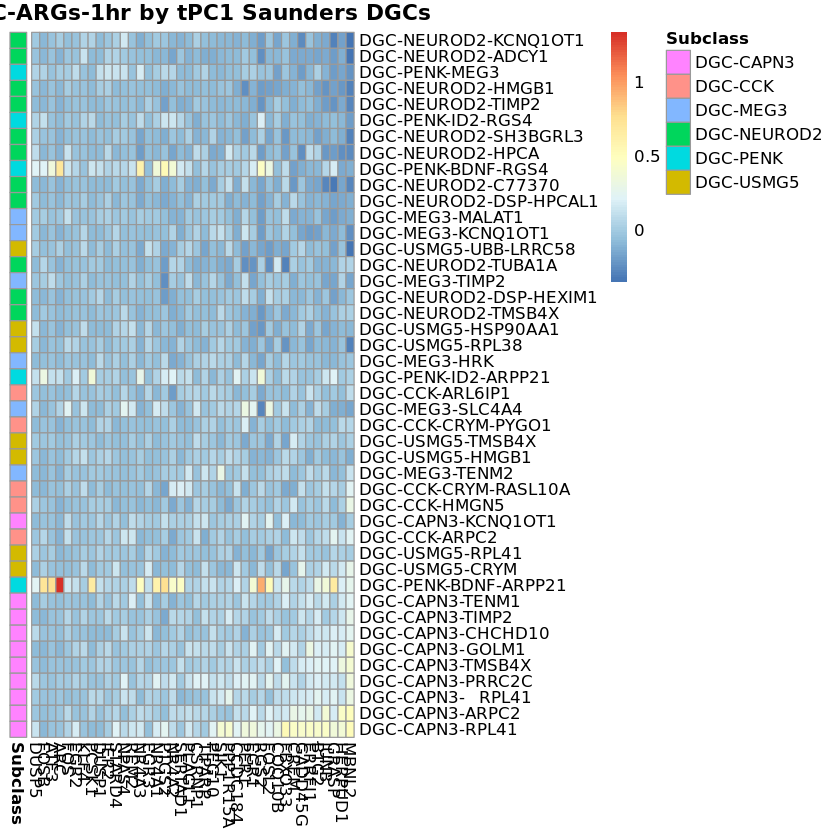

In [166]:
df <- iegsbytpc1.subtype_means.df %>% 
        select(-iegsum_activity) %>%
        select(-tPC1_score)

temp_hm <-pheatmap(df,
                   cluster_rows = FALSE, cluster_cols = FALSE,
                   annotation_row = subclass.df,
                   main = "DGC-ARGs-1hr by tPC1 Saunders DGCs")